In [7]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.easter import easter
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [8]:
monthly_data = pd.read_csv("monthly_data.csv")

c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\30467\AppData\Local\Programs\Python\Python311\L

模型评估指标（基于价格）:
RMSE: 32.9945
MAE:  878.6993
MAPE: 11.02%


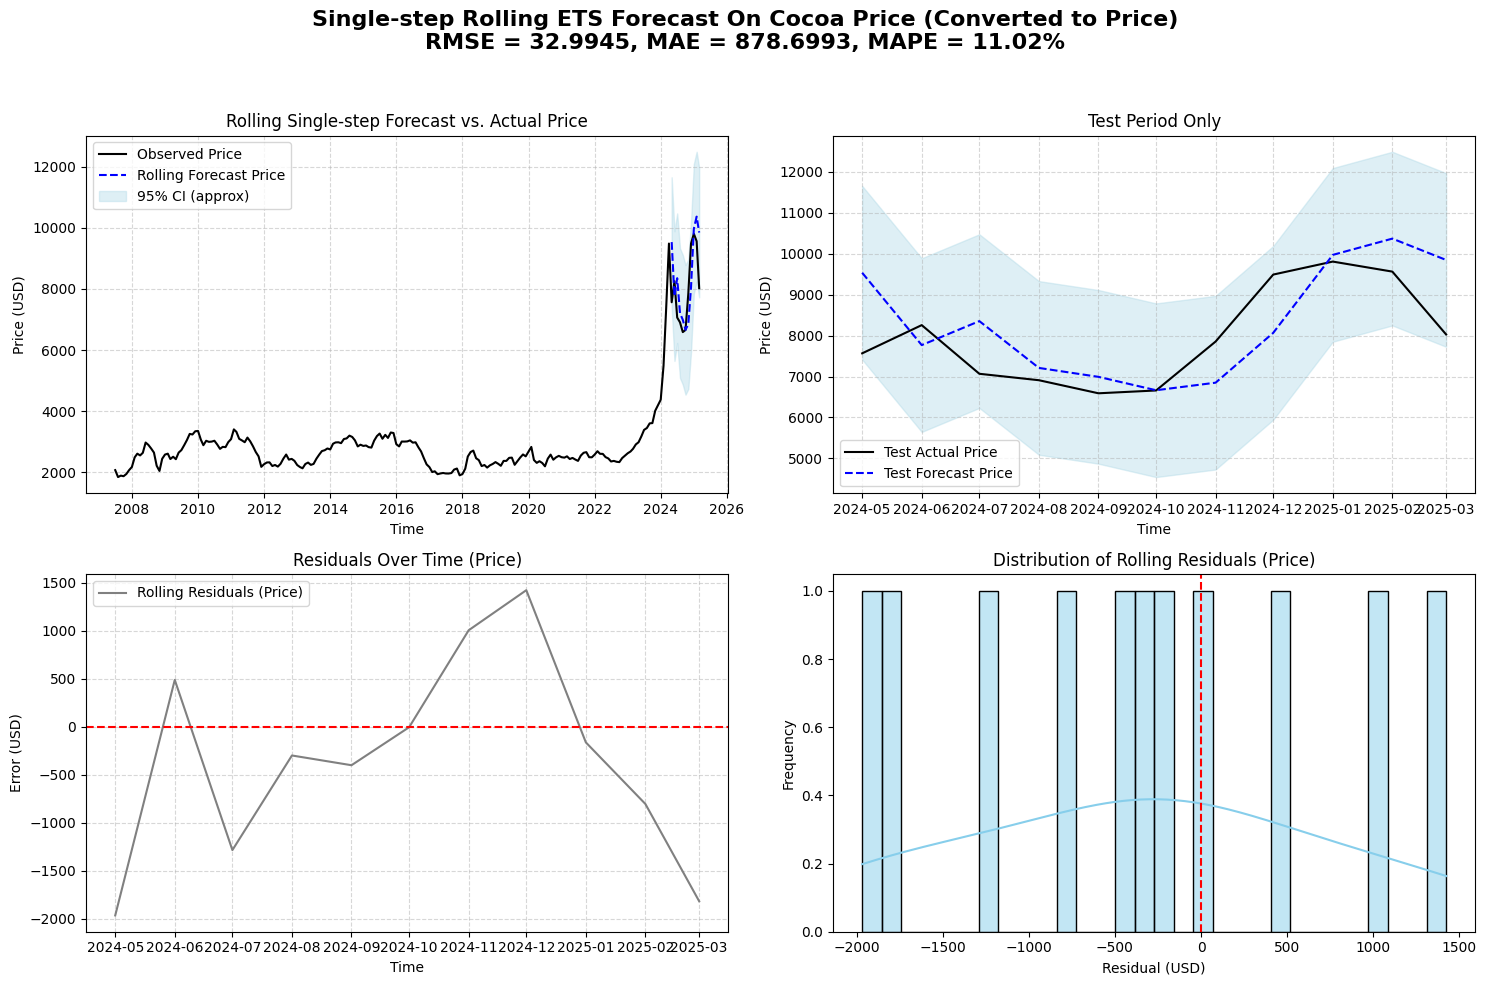

In [11]:
monthly_data["Month"] = pd.to_datetime(monthly_data["Month"], errors='coerce')

monthly_data_ts = monthly_data.set_index("Month")

price_series = monthly_data_ts["Price_NY"]
log_return_series = monthly_data_ts["log_return_rate"].dropna()

n = len(log_return_series)
train_size = int(n * 0.95)
train_return_series = log_return_series.iloc[:train_size]
test_return_series = log_return_series.iloc[train_size:]

rolling_forecasts = {}       
rolling_price_predictions = {}
rolling_residuals = {}       


test_index = test_return_series.index

for test_date in test_index:

    current_train_data = log_return_series.loc[:test_date].iloc[:-1]
    
    ets_model = ETSModel(
        current_train_data,
        error="add",
        trend="add",
        seasonal="add",
        seasonal_periods=12
    )
    ets_result = ets_model.fit()

    forecast_log_return = ets_result.forecast(steps=1).iloc[0]
    rolling_forecasts[test_date] = forecast_log_return
    
    prev_price = price_series.loc[price_series.index < test_date].iloc[-1]
    predicted_price = prev_price * np.exp(forecast_log_return)
    
    rolling_price_predictions[test_date] = predicted_price
    
    actual_price = price_series.loc[test_date]
    rolling_residuals[test_date] = actual_price - predicted_price

rolling_forecast_series = pd.Series(rolling_forecasts)            
predicted_price_series = pd.Series(rolling_price_predictions)   
rolling_residual_series = pd.Series(rolling_residuals)          

true_price_series = price_series.loc[test_index]

rmse_price = np.sqrt(root_mean_squared_error(true_price_series, predicted_price_series))
mae_price = mean_absolute_error(true_price_series, predicted_price_series)
mape_price = mean_absolute_percentage_error(true_price_series, predicted_price_series) * 100

print("模型评估指标（基于价格）:")
print(f"RMSE: {rmse_price:.4f}")
print(f"MAE:  {mae_price:.4f}")
print(f"MAPE: {mape_price:.2f}%")

resid_std = rolling_residual_series.std()
z = 1.96

ci_upper = predicted_price_series + z * resid_std
ci_lower = predicted_price_series - z * resid_std

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle(
    f"Single-step Rolling ETS Forecast On Cocoa Price (Converted to Price)\n"
    f"RMSE = {rmse_price:.4f}, MAE = {mae_price:.4f}, MAPE = {mape_price:.2f}%",
    fontsize=16, weight="bold"
)

axes[0, 0].plot(price_series, label="Observed Price", color="black")
axes[0, 0].plot(predicted_price_series, label="Rolling Forecast Price", color="blue", linestyle="--")
axes[0, 0].fill_between(predicted_price_series.index, ci_lower, ci_upper, 
                        color="lightblue", alpha=0.4, label="95% CI (approx)")
axes[0, 0].set_title("Rolling Single-step Forecast vs. Actual Price", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

axes[0, 1].plot(true_price_series, label="Test Actual Price", color="black")
axes[0, 1].plot(predicted_price_series, label="Test Forecast Price", color="blue", linestyle="--")
axes[0, 1].fill_between(predicted_price_series.index, ci_lower, ci_upper, 
                        color="lightblue", alpha=0.4)
axes[0, 1].set_title("Test Period Only", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

axes[1, 0].plot(rolling_residual_series, label="Rolling Residuals (Price)", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (Price)", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Error (USD)")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

sns.histplot(rolling_residual_series, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Rolling Residuals (Price)", fontsize=12)
axes[1, 1].set_xlabel("Residual (USD)")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Multi-step ETS Forecast (log_return_rate -> Price)
RMSE : 53.39
MAE  : 2691.88
MAPE : 35.50%


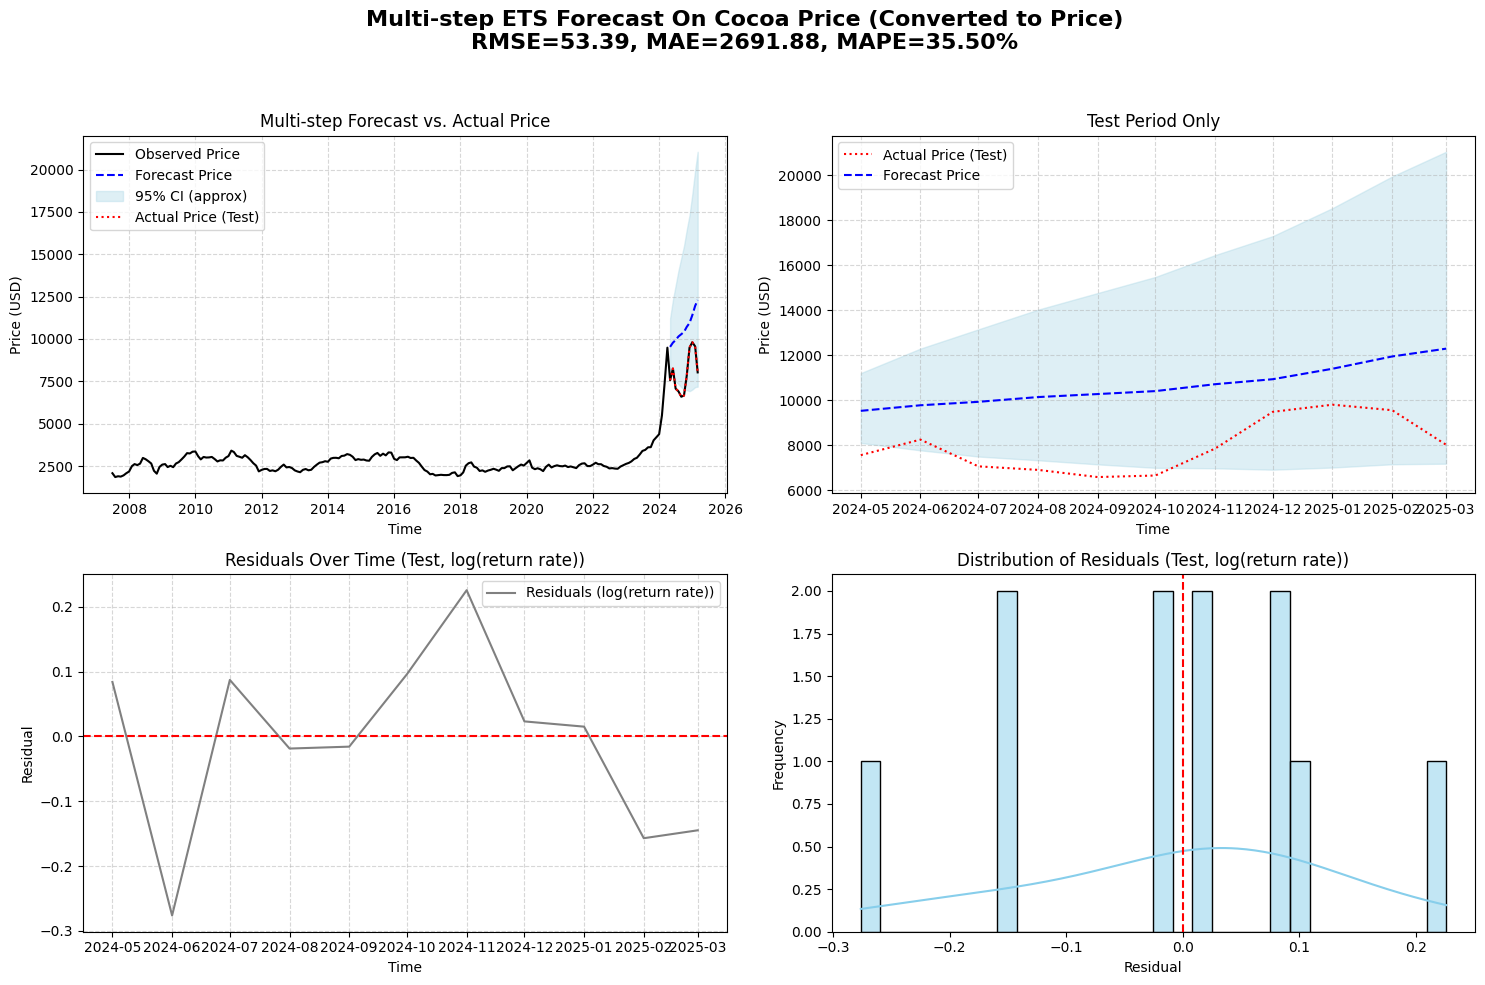

In [12]:
monthly_data["Month"] = pd.to_datetime(monthly_data["Month"], errors='coerce')
monthly_data_ts = monthly_data.set_index("Month")
log_return_series = monthly_data_ts["log_return_rate"].dropna()
price_series = monthly_data_ts["Price_NY"]

n = len(log_return_series)
train_size = int(n * 0.95)

train_return_series = log_return_series.iloc[:train_size]
test_return_series  = log_return_series.iloc[train_size:]
test_steps = len(test_return_series) 

# ETS 模型拟合（训练集）
ets_model = ETSModel(
    train_return_series,
    error="add",     # 可根据需求调整
    trend="add",     
    seasonal="add",  
    seasonal_periods=12
)
ets_result = ets_model.fit()

# 一次性预测未来 test_steps 步的对数收益率（测试期预测）
forecast_log_return = ets_result.forecast(steps=test_steps)  # pd.Series

# =============================================
# 3) 将 log_return_rate 的多步预测转换为价格
# =============================================
last_train_date = train_return_series.index[-1]
base_price = price_series.loc[last_train_date]

cum_forecast_log = forecast_log_return.cumsum()
predicted_price = base_price * np.exp(cum_forecast_log)

actual_price = price_series.loc[forecast_log_return.index]

# =============================================
# 4) 评估指标 (基于价格)
# =============================================
rmse = np.sqrt(root_mean_squared_error(actual_price, predicted_price))
mae = mean_absolute_error(actual_price, predicted_price)
mape = mean_absolute_percentage_error(actual_price, predicted_price)*100

print("Multi-step ETS Forecast (log_return_rate -> Price)")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

# =============================================
# 5) 简易置信区间 (在对数收益率空间)
# =============================================
residuals_train = ets_result.resid  # 训练残差，用于估计标准差
resid_std = residuals_train.std()
z = 1.96

ci_lower = []
ci_upper = []
for i, (idx, val) in enumerate(forecast_log_return.items(), start=1):
    cumsum_lower = forecast_log_return.iloc[:i].sum() - z * np.sqrt(i) * resid_std
    cumsum_upper = forecast_log_return.iloc[:i].sum() + z * np.sqrt(i) * resid_std
    price_l = base_price * np.exp(cumsum_lower)
    price_u = base_price * np.exp(cumsum_upper)
    ci_lower.append(price_l)
    ci_upper.append(price_u)

ci_lower = pd.Series(ci_lower, index=forecast_log_return.index)
ci_upper = pd.Series(ci_upper, index=forecast_log_return.index)

# =============================================
# 6) 计算测试集在对数收益率空间的残差
# =============================================
# 这里使用测试期实际对数收益率减去 ETS 模型的预测对数收益率
test_residuals = test_return_series - forecast_log_return

# =============================================
# 7) 绘图 (2×2 面板)
# =============================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle(
    f"Multi-step ETS Forecast On Cocoa Price (Converted to Price)\n"
    f"RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%",
    fontsize=16, weight="bold"
)

# (1) 全系列价格 + 预测
axes[0, 0].plot(price_series, label="Observed Price", color="black")
axes[0, 0].plot(predicted_price.index, predicted_price, label="Forecast Price", color="blue", linestyle="--")
axes[0, 0].fill_between(predicted_price.index, ci_lower, ci_upper, color="lightblue", alpha=0.4, label="95% CI (approx)")
axes[0, 0].plot(actual_price.index, actual_price, label="Actual Price (Test)", color="red", linestyle="dotted")
axes[0, 0].set_title("Multi-step Forecast vs. Actual Price", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# (2) 仅测试期放大
axes[0, 1].plot(actual_price, label="Actual Price (Test)", color="red", linestyle="dotted")
axes[0, 1].plot(predicted_price.index, predicted_price, label="Forecast Price", color="blue", linestyle="--")
axes[0, 1].fill_between(predicted_price.index, ci_lower, ci_upper, color="lightblue", alpha=0.4)
axes[0, 1].set_title("Test Period Only", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# (3) 测试集残差（在 log_return_rate 空间）
axes[1, 0].plot(test_residuals, label="Residuals (log(return rate))", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (Test, log(return rate))", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Residual")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# (4) 残差分布直方图（在 log_return_rate 空间）
sns.histplot(test_residuals, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Residuals (Test, log(return rate))", fontsize=12)
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
